In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [7]:
##################################################
####### import function 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


## Figure S22. Water vapour adsorption isotherms of lead desiccant candidates at 27 °C

In [8]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx',
           'ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls',
           'ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls',
            'CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx',
           'MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls',
           'MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls',
           'Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls',
            'Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls',
           ]

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx':{'color':'tab:blue', 'name':'CAU-10-H'},
                             'MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls':{'color':'grey', 'name':'Syloid'},
                            'Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls':{'color':'pink', 'name':'Al-fumarate'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

File ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx read succesfull
File ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls read succesfull
File ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls read succesfull
File CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx read succesfull
File MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls read succesfull
File MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls read succesfull
File Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls read succesfull
File Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls read succesfull


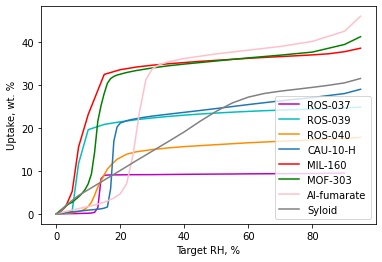

In [9]:
def add_picture_WaterSorption_isotherm(Sorption_list, dpi, width, height):
    fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))
    for m, Sorption in enumerate(Sorption_list):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        #print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        #print(args)
        
        for start,  end in zip(args, args[1:]):
            #print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
            if True:
                ax1.plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                         c=name_and_color_dictionary[Sorption.filename]['color'],
                         label=name_and_color_dictionary[Sorption.filename]['name'])
                #ax1.scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                #            c=name_and_color_dictionary[Sorption.filename]['color'],
                #           s=6
                #           )
                #ax1.plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],c=color_list[m], linestyle='dashed')
                #ax1.scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  facecolors='w', edgecolors=color_list[m])
                ax1.set_xlabel('Target RH, %')
                ax1.set_ylabel('Uptake, wt. %')
                #ax1.set_title('File: '+Sorption.filename)
                

    ax1.legend()        
    #ax1.set_xlim([0,60])
    #ax1.set_ylim([0,40])
    plt.savefig('Figure_isotherm_8sorbents.png', dpi=dpi)
    plt.show()


if Water_Sorption_list !=[]:
    add_picture_WaterSorption_isotherm(Water_Sorption_list,  dpi=300, width=15, height=6)
 

## Figures S23-S30

[]
[0, 158535]


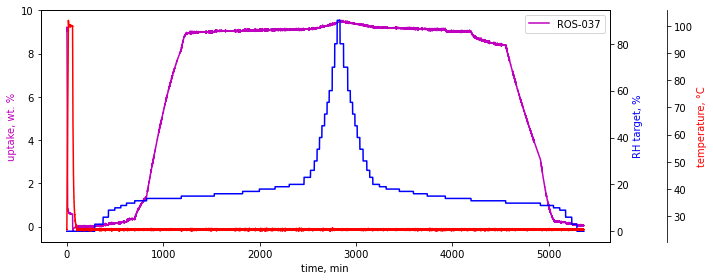

[]
[0, 158535]
0 158535


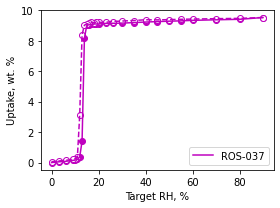

[]
[0, 38210]


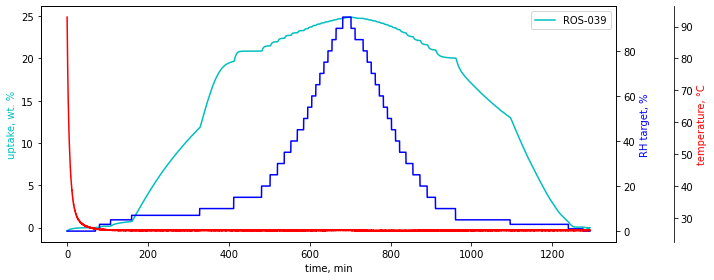

[]
[0, 38210]
0 38210


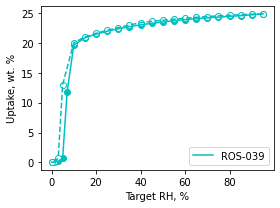

[]
[0, 53938]


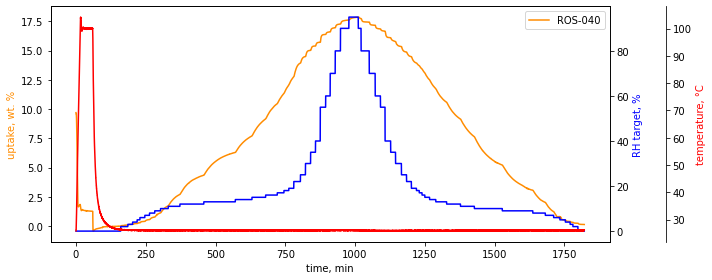

[]
[0, 53938]
0 53938


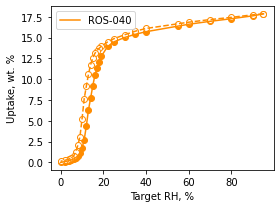

[]
[0, 69627]


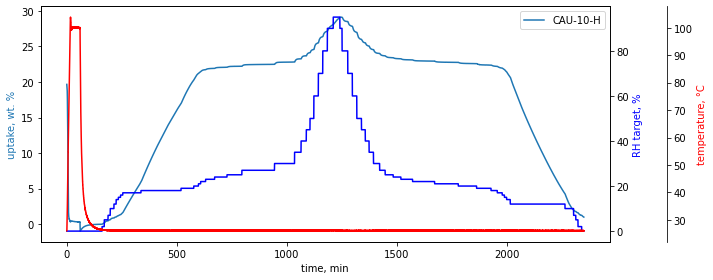

[]
[0, 69627]
0 69627


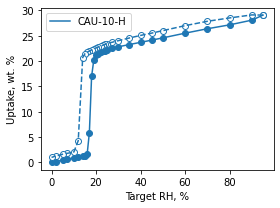

[]
[0, 38210]


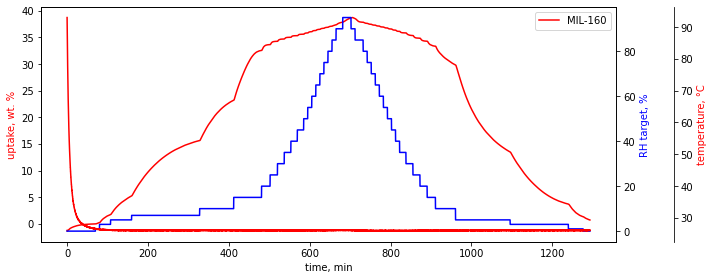

[]
[0, 38210]
0 38210


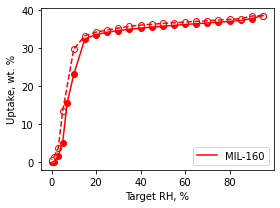

[]
[0, 53938]


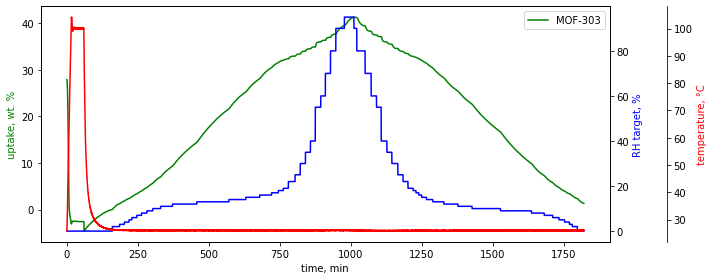

[]
[0, 53938]
0 53938


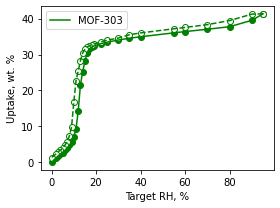

[]
[0, 64118]


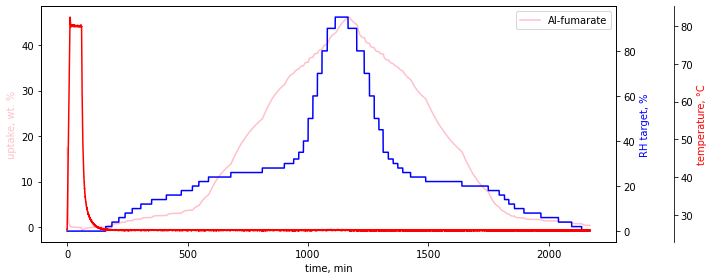

[]
[0, 64118]
0 64118


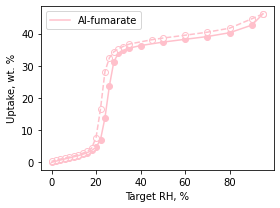

[]
[0, 41880]


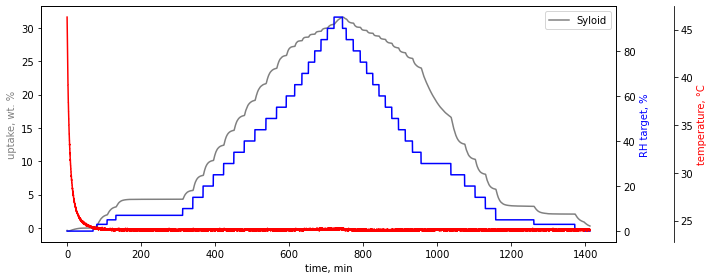

[]
[0, 41880]
0 41880


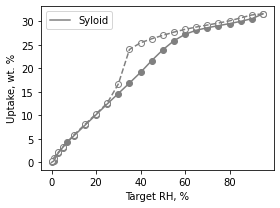

In [10]:
def add_picture_WaterSorption_isotherm(Sorption_list, dpi, width, height):
    
    for m, Sorption in enumerate(Sorption_list):
        fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        ax1.plot(Sorption.data.time, 
                 Sorption.data.uptake,
                 c=name_and_color_dictionary[Sorption.filename]['color'],
                 label=name_and_color_dictionary[Sorption.filename]['name'])
        ax1.set_xlabel('time, min')
        ax1.set_ylabel('uptake, wt. %', c=name_and_color_dictionary[Sorption.filename]['color'],)
        ax2 = ax1.twinx()
        ax2.plot(Sorption.data.time, 
                 Sorption.data.RH_target,
                 c='b',
                 label=name_and_color_dictionary[Sorption.filename]['name'])
        ax2.set_ylabel('RH target, %', c='b')
        ax3 = ax1.twinx()
        ax3.spines.right.set_position(("axes", 1.1))
        ax3.plot(Sorption.data.time, 
                 Sorption.data.temp_actual,
                 c='r',
                 label=name_and_color_dictionary[Sorption.filename]['name'])
        ax3.set_ylabel('temperature, °C', c='r')
        #ax1.set_title('File: '+Sorption.filename)
        ax1.legend()        
        #ax1.set_xlim([0,60])
        #ax1.set_ylim([0,40])
        plt.tight_layout()
        plt.savefig('Figure_isotherm+kin_{}.png'.format(Sorption.filename.split('/')[-1]), dpi=dpi)
        plt.show()

        #################################
        ###    plot isotherms         ###
        #################################        
        fig, (ax1) = plt.subplots(1, 1, figsize=(4,3))
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()

        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)

        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()

            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]

            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
            ax1.plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                     c=name_and_color_dictionary[Sorption.filename]['color'],
                     label=name_and_color_dictionary[Sorption.filename]['name'])
            ax1.scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                            c=name_and_color_dictionary[Sorption.filename]['color'],
                           )
            ax1.plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],
                         c=name_and_color_dictionary[Sorption.filename]['color'], linestyle='dashed')
            ax1.scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  
                            facecolors='w', edgecolors=name_and_color_dictionary[Sorption.filename]['color'],
                           )
            ax1.set_xlabel('Target RH, %', fontsize=10)
            ax1.set_ylabel('Uptake, wt. %', fontsize=10)

            #ax[0, m].set_xlim([0, 30])
            ax1.legend()
            #x[0, m].set_title('File: '+Sorption.filename)
            fig.tight_layout()
            plt.savefig('Figure_isotherm_{}.png'.format(Sorption.filename.split('/')[-1]), dpi=dpi)
            plt.show()

if Water_Sorption_list !=[]:
    add_picture_WaterSorption_isotherm(Water_Sorption_list,  dpi=300, width=15, height=6)
 

## Figure S31

File Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls read succesfull
File ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls read succesfull
File ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls read succesfull
File ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls read succesfull
File Al-fumarate/27C/Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls read succesfull
File CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls read succesfull
File MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls read succesfull
File MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls read succesfull
[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <A

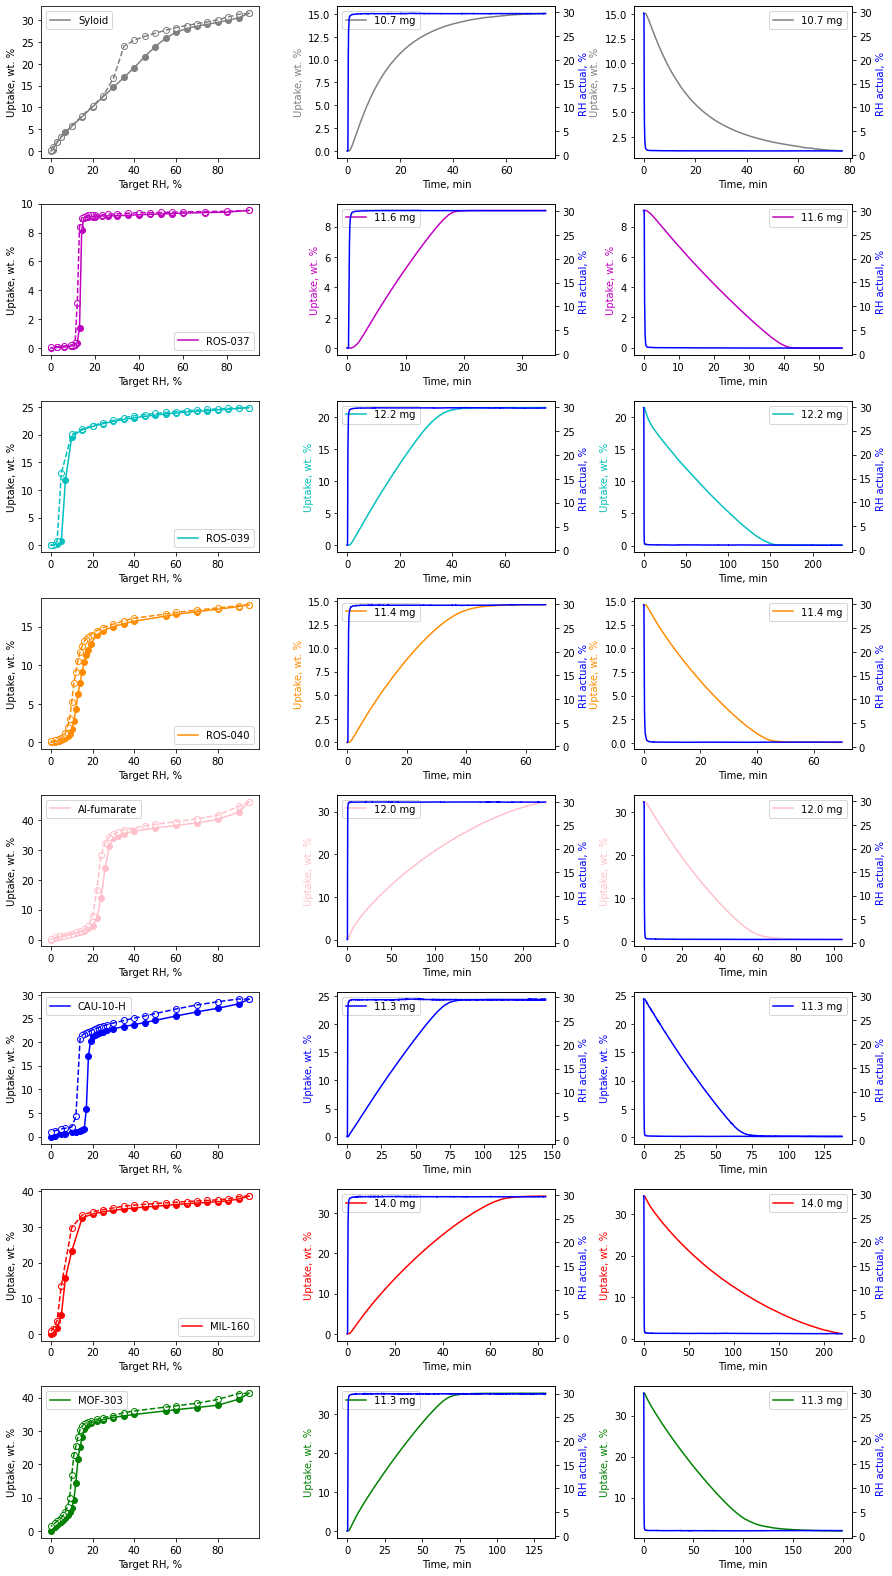

In [11]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls',
            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls',
            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls',
            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls',
            'Al-fumarate/27C/Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls',
            'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls',
            'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls',
            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls',
           
           ]

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls':{'color':'grey', 'name':'Syloid'},
                            'Al-fumarate/27C/Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls':{'color':'pink', 'name':'Al-fumarate'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')
        
fig, ax = plt.subplots(8, 3, figsize=(12.5,22))

#################################
###    plot kinetics          ###
#################################
print(ax)
for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
    ax[m, 1].plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
             Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label='{0:.1f} mg'.format(Sorption.sample_mass)
                )
    ax1 = ax[m, 1].twinx()
    ax1.plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
             Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['RH_actual'], 
             c='b',
             )
    ax1.set_ylabel('RH actual, % ', fontsize=10, c='b')
    ax[m, 1].set_xlabel('Time, min', fontsize=10)
    ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, c=name_and_color_dictionary[Sorption.filename]['color'],)
    ax[m, 1].legend()
    ax[m, 2].plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
             Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['uptake'], 
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label='{0:.1f} mg'.format(Sorption.sample_mass)
                )
    ax2 = ax[m, 2].twinx()
    ax2.plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
             Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['RH_actual'], 
             c='b'
                )
    ax2.set_ylabel('RH actual, % ', fontsize=10, c='b')
    ax[m, 2].set_xlabel('Time, min', fontsize=10)
    ax[m, 2].set_ylabel('Uptake, wt. %', fontsize=10, c=name_and_color_dictionary[Sorption.filename]['color'],)
    ax[m, 2].legend()
    
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls',
            'ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx',
            'ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls',
            'ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls',
            'Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls',
            'CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx',
           'MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls',
            'MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls',

           ]

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls':{'color':'grey', 'name':'Syloid'},
                            'Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls':{'color':'pink', 'name':'Al-fumarate'},
                            }


Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

#################################
###    plot isotherms         ###
#################################        

for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()

    index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
    index_tuple = sorted(index_tuple, key=lambda x: x[1])
    #print(index_tuple)
    isotherm_split = []
    prev = 'ads'
    for i, j in enumerate([i[0] for i in index_tuple]):
        if (j == 'ads')&(prev=='des'):
            isotherm_split.append(index_tuple[i][1])
        prev = j
    print(isotherm_split)
    args = [0]+isotherm_split+[Sorption.data.index.size]
    #args= args[:2]
    print(args)

    for start,  end in zip(args, args[1:]):
        print(start,  end)
        split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()

        split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
        split_index_ads = split_index_ads + [split_index_des[0]]

        #print(split_index_ads)
        #print(split_index_des)
        isotherm_RHtarget_ads = []
        isotherm_RHactual_ads = []
        isotherm_adsorption = []
        isotherm_RHtarget_des = []
        isotherm_RHactual_des = []
        isotherm_desorption = []
        for i, split in enumerate(split_index_ads[:]):
            isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
            if i==0:
                isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
            else:
                isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
        for i, split in enumerate(split_index_des[:]):
            isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
            if i == 0:
                isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
            else:
                isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
        ax[m, 0].plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                 c=name_and_color_dictionary[Sorption.filename]['color'],
                 label=name_and_color_dictionary[Sorption.filename]['name'])
        ax[m, 0].scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                        c=name_and_color_dictionary[Sorption.filename]['color'],
                       )
        ax[m, 0].plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],
                     c=name_and_color_dictionary[Sorption.filename]['color'], linestyle='dashed')
        ax[m, 0].scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  
                        facecolors='w', edgecolors=name_and_color_dictionary[Sorption.filename]['color'],
                       )
        ax[m, 0].set_xlabel('Target RH, %', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10)
        
        #ax[0, m].set_xlim([0, 30])
        ax[m, 0].legend()
        #x[0, m].set_title('File: '+Sorption.filename)
fig.tight_layout()
plt.show()

## Figure S32

File Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls read succesfull
File ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls read succesfull
File ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls read succesfull
File ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls read succesfull
File Al-fumarate/27C/Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls read succesfull
File CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls read succesfull
File MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls read succesfull
File MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls read succesfull
[[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <A

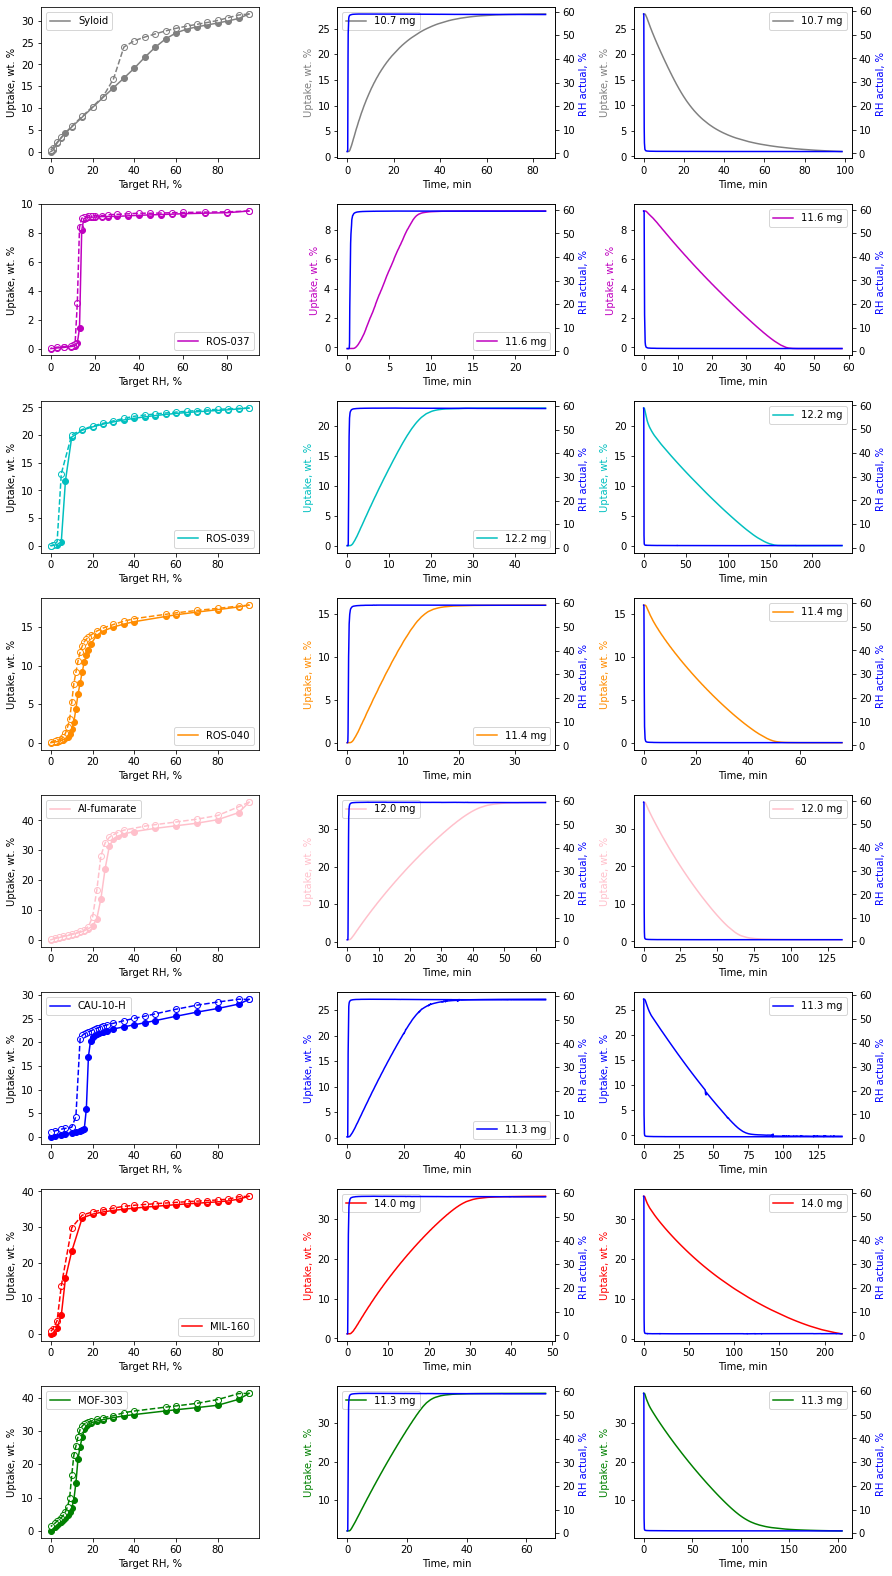

In [12]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls',
            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls',
            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls',
            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls',
            'Al-fumarate/27C/Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls',
            'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls',
            'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls',
            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls',
           
           ]

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-153_kinetics_12mg_27C_50-100um-2021-06-24 13-11-08_1.xls':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/MIL-160_DJO-02-500_kinetics_27C_14mg_50-100um-2021-06-17 14-20-40_1.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303-SS1131_kinetics_27C_12mg_50-100um-2021-06-03 09-37-23.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-1-82_kinetics_12mg_27C_50-100um-2021-06-30 09-53-50.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls':{'color':'grey', 'name':'Syloid'},
                            'Al-fumarate/27C/Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-19 16-39-52.xls':{'color':'pink', 'name':'Al-fumarate'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')
        
fig, ax = plt.subplots(8, 3, figsize=(12.5,22))

#################################
###    plot kinetics          ###
#################################
print(ax)
for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==60)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-60)].to_list()
    ax[m, 1].plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
             Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label='{0:.1f} mg'.format(Sorption.sample_mass)
                )
    ax1 = ax[m, 1].twinx()
    ax1.plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
             Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['RH_actual'], 
             c='b',
             )
    ax1.set_ylabel('RH actual, % ', fontsize=10, c='b')
    ax[m, 1].set_xlabel('Time, min', fontsize=10)
    ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, c=name_and_color_dictionary[Sorption.filename]['color'],)
    ax[m, 1].legend()
    ax[m, 2].plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
             Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['uptake'], 
             c=name_and_color_dictionary[Sorption.filename]['color'],
             label='{0:.1f} mg'.format(Sorption.sample_mass)
                )
    ax2 = ax[m, 2].twinx()
    ax2.plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
             Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['RH_actual'], 
             c='b'
                )
    ax2.set_ylabel('RH actual, % ', fontsize=10, c='b')
    ax[m, 2].set_xlabel('Time, min', fontsize=10)
    ax[m, 2].set_ylabel('Uptake, wt. %', fontsize=10, c=name_and_color_dictionary[Sorption.filename]['color'],)
    ax[m, 2].legend()
    
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

filelist = ['Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls',
            'ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx',
            'ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls',
            'ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls',
            'Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls',
            'CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx',
           'MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls',
            'MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls',

           ]

# color list
name_and_color_dictionary = {'CAU-10/27C/CAU-10-H_NK-1-1531_isotherm_-2021-06-12 15-33-08.xlsx':{'color':'b', 'name':'CAU-10-H'},
                             'MIL-160/27C/DJO-02-500_isotherm_27C-2021-05-18 18-59-58.xls':{'color':'r', 'name':'MIL-160'},
                            'MOF-303/27C/MOF-303_SS-1131_isotherm_27C-2021-06-14 09-53-10.xls':{'color':'g', 'name':'MOF-303'},
                            'ROS-037/27C/ROS037_-u50_isotherm-2021-05-07 18-07-06.xlsx':{'color':'m', 'name':'ROS-037'},
                            'ROS-039/27C/SD-1-183_isotherm_27C-2021-05-18 18-59-58.xls':{'color':'c', 'name':'ROS-039'},
                            'ROS-040/27C/ROS-040_SD-01-082_isotherm_27C-2021-06-14 09-53-10.xls':{'color':'darkorange', 'name':'ROS-040'},
                            'Syloid/27C/syloid_isotherm_25C-2021-03-19 23-03-21.xls':{'color':'grey', 'name':'Syloid'},
                            'Al-fumarate/27C/NK1091_Al-fumarate_EtOH_50-100um_27C_isotherm-2022-01-07 09-05-27.xls':{'color':'pink', 'name':'Al-fumarate'},
                            }


Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')

#################################
###    plot isotherms         ###
#################################        

for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()

    index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
    index_tuple = sorted(index_tuple, key=lambda x: x[1])
    #print(index_tuple)
    isotherm_split = []
    prev = 'ads'
    for i, j in enumerate([i[0] for i in index_tuple]):
        if (j == 'ads')&(prev=='des'):
            isotherm_split.append(index_tuple[i][1])
        prev = j
    print(isotherm_split)
    args = [0]+isotherm_split+[Sorption.data.index.size]
    #args= args[:2]
    print(args)

    for start,  end in zip(args, args[1:]):
        print(start,  end)
        split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()

        split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
        split_index_ads = split_index_ads + [split_index_des[0]]

        #print(split_index_ads)
        #print(split_index_des)
        isotherm_RHtarget_ads = []
        isotherm_RHactual_ads = []
        isotherm_adsorption = []
        isotherm_RHtarget_des = []
        isotherm_RHactual_des = []
        isotherm_desorption = []
        for i, split in enumerate(split_index_ads[:]):
            isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
            if i==0:
                isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
            else:
                isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
        for i, split in enumerate(split_index_des[:]):
            isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
            if i == 0:
                isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
            else:
                isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
        ax[m, 0].plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                 c=name_and_color_dictionary[Sorption.filename]['color'],
                 label=name_and_color_dictionary[Sorption.filename]['name'])
        ax[m, 0].scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                        c=name_and_color_dictionary[Sorption.filename]['color'],
                       )
        ax[m, 0].plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],
                     c=name_and_color_dictionary[Sorption.filename]['color'], linestyle='dashed')
        ax[m, 0].scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  
                        facecolors='w', edgecolors=name_and_color_dictionary[Sorption.filename]['color'],
                       )
        ax[m, 0].set_xlabel('Target RH, %', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10)
        
        #ax[0, m].set_xlim([0, 30])
        ax[m, 0].legend()
        #x[0, m].set_title('File: '+Sorption.filename)
fig.tight_layout()
plt.show()

## Figures S33-34

In [14]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/'

path_list = ['Syloid/27C/',
            'ROS-037/27C/',
            'ROS-039/27C/',
            'ROS-040/27C/',
            'Al-fumarate/27C/',
            'CAU-10/27C/',
            'MIL-160/27C/',
            'MOF-303/27C/',
           ]

Water_Sorption_list = []
for pathname in path_list:
    Water_Sorption_list_path = []
    for Sorption_filename in [i for i in os.listdir(path+pathname) if 'isotherm' not in i]:
        Sorption = file_Sorption()
        try:
            Sorption.read_file(path+pathname,Sorption_filename)
            if Sorption.import_success:
                Water_Sorption_list_path.append(Sorption)
            else:
                del Sorption
                print(Sorption_filename, 'failed')
        except Exception as e:
            print(e)
            print(Sorption_filename, 'failed')
    Water_Sorption_list.append(sorted([(i, i.sample_mass) for i in Water_Sorption_list_path], key=lambda x: x[1])) 
    

[Errno 13] Permission denied: '../../data/Syloid/27C/hm'
hm failed
File syloid_kinetics_50-100um_12mg_27C-2021-07-08 14-48-29.xls read succesfull
File syloid_kinetics_50-100um_20mg_27C-2021-07-08 14-48-29.xls read succesfull
File Syloid_kinetics_50-100um_27C_12mg-2021-07-15 13-38-52.xls read succesfull
File Syloid_kinetics_50-100um_27C_5mg-2021-07-15 13-38-52.xls read succesfull
File 400flow-ROS-037_pureBatch_50-100um_10mg_flowRateVariation-2021-05-25 14-51-36.xls read succesfull
File 400flow-ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-25 14-51-36.xls read succesfull
[Errno 13] Permission denied: '../../data/ROS-037/27C/hm'
hm failed
File ROS-037_pureBatch_50-100um_5mg_27C_12mg-2021-08-21 16-34-05.xls read succesfull
File ROS-037_pureBatch_50-100um_5mg_27C_15mg-2021-08-21 16-34-05.xls read succesfull
[Errno 13] Permission denied: '../../data/ROS-039/27C/hm'
hm failed
File ROS039-SD-1-183_kinetics_12mg_50-100um-2021-06-05 12-06-31.xls read succesfull
File ROS039-SD-1-183_ki

#### 0-30% RH swing

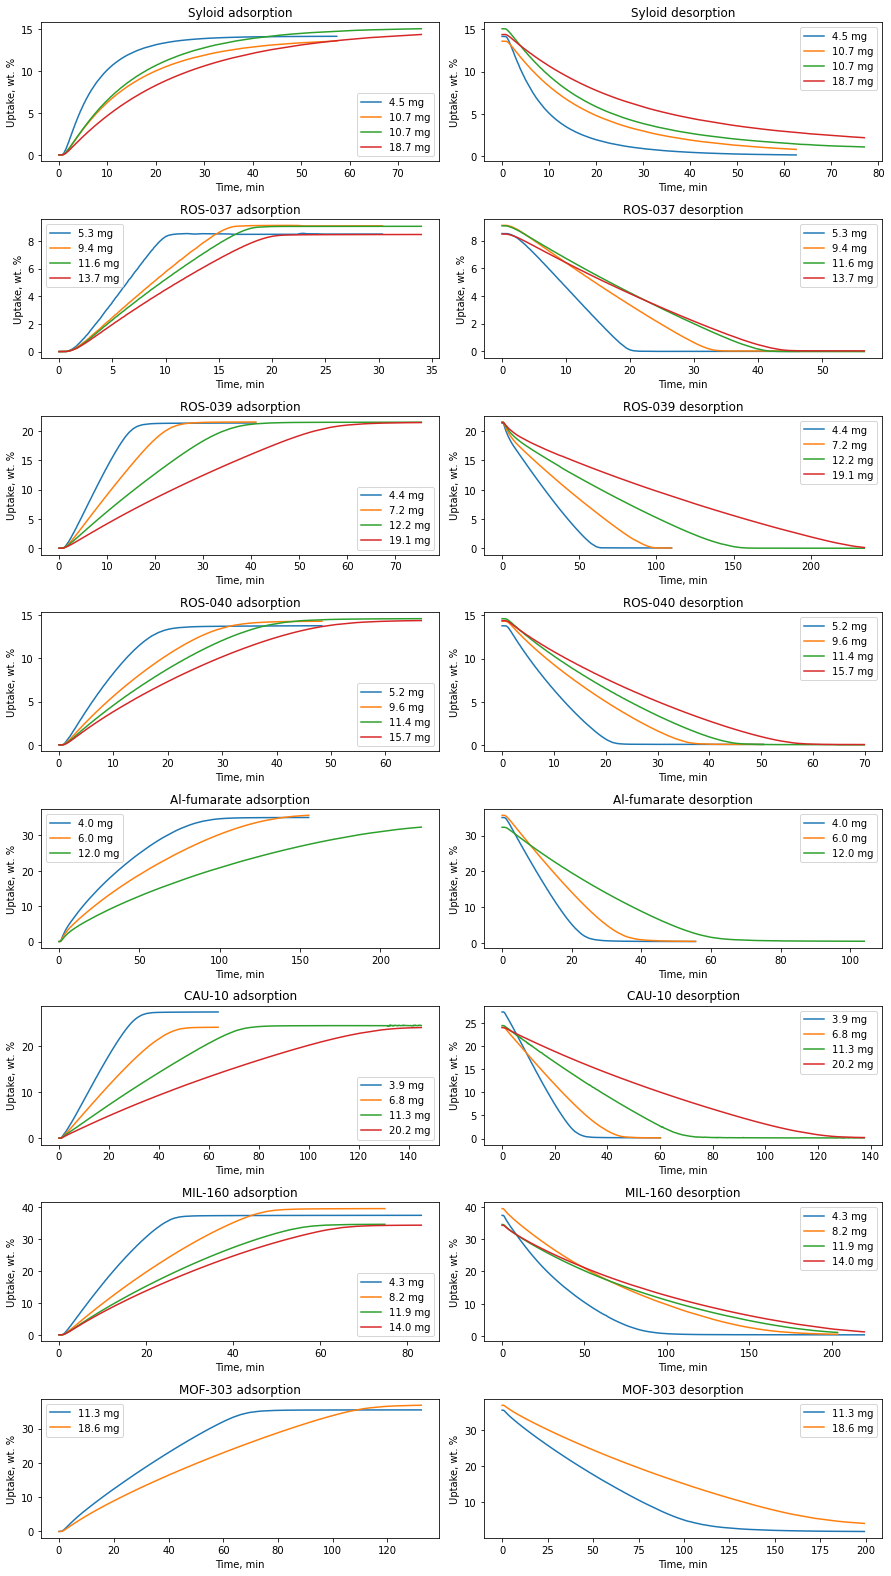

In [15]:
#################################
###    plot kinetics          ###
#################################
fig, ax = plt.subplots(8, 2, figsize=(12.5,22))

for m, Sorption_list in enumerate( Water_Sorption_list):
    for i, Sorption in enumerate([i[0] for i in Sorption_list]):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
        ax[m, 0].plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
                 Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
                 label='{0:.1f} mg'.format(Sorption.sample_mass)
                    )
        ax[m, 0].set_xlabel('Time, min', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 0].legend()
        ax[m, 1].plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
                 Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['uptake'], 
                 label='{0:.1f} mg'.format(Sorption.sample_mass)
                    )
        ax[m, 1].set_xlabel('Time, min', fontsize=10)
        ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 1].legend()
    ax[m, 0].set_title('{0} adsorption'.format(path_list[m].split('/')[0]))
    ax[m, 1].set_title('{0} desorption'.format(path_list[m].split('/')[0]))
    

fig.tight_layout()
plt.show()

#### 0-60% RH swing

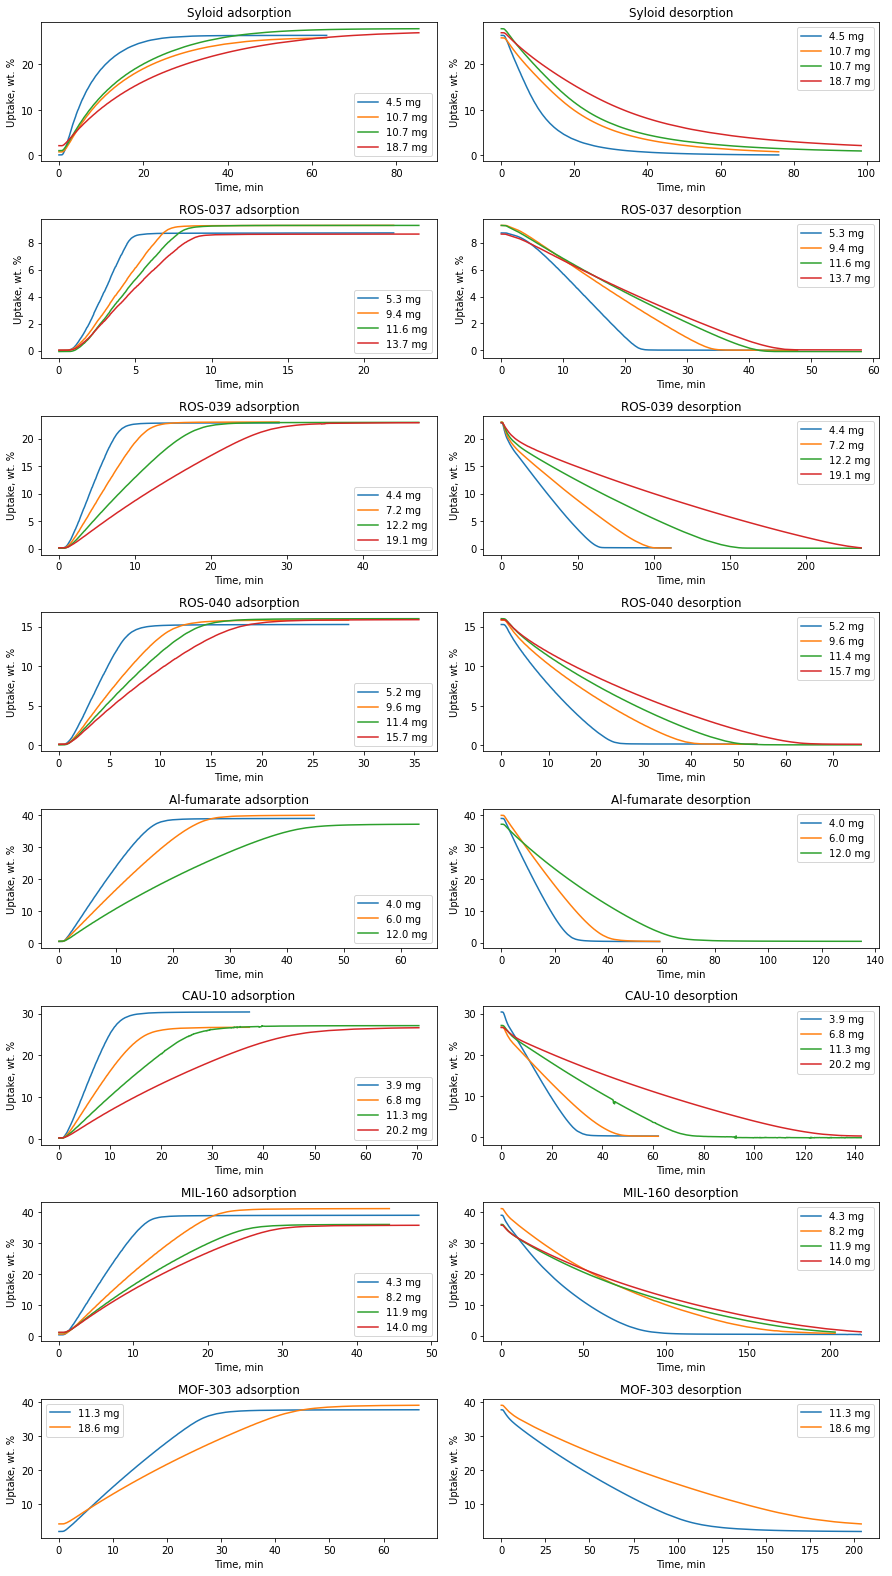

In [16]:
#################################
###    plot kinetics          ###
#################################
fig, ax = plt.subplots(8, 2, figsize=(12.5,22))

for m, Sorption_list in enumerate( Water_Sorption_list):
    for i, Sorption in enumerate([i[0] for i in Sorption_list]):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==60)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-60)].to_list()
        ax[m, 0].plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
                 Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
                 label='{0:.1f} mg'.format(Sorption.sample_mass)
                    )
        ax[m, 0].set_xlabel('Time, min', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 0].legend()
        ax[m, 1].plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
                 Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['uptake'], 
                 label='{0:.1f} mg'.format(Sorption.sample_mass)
                    )
        ax[m, 1].set_xlabel('Time, min', fontsize=10)
        ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 1].legend()
    ax[m, 0].set_title('{0} adsorption'.format(path_list[m].split('/')[0]))
    ax[m, 1].set_title('{0} desorption'.format(path_list[m].split('/')[0]))
    

fig.tight_layout()
plt.show()

## Figures S35-S36

In [17]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/different_fractions/'

path_list = ['CAU-10-H/',
            'MIL-160/',
            'MOF-303/',
            'Syloid/',
           ]

Water_Sorption_list = []
for pathname in path_list:
    Water_Sorption_list_path = []
    for Sorption_filename in [i for i in os.listdir(path+pathname) if 'isotherm' not in i]:
        Sorption = file_Sorption()
        try:
            Sorption.read_file(path+pathname,Sorption_filename)
            if Sorption.import_success:
                Water_Sorption_list_path.append(Sorption)
            else:
                del Sorption
                print(Sorption_filename, 'failed')
        except Exception as e:
            print(e)
            print(Sorption_filename, 'failed')
    Water_Sorption_list.append(sorted([(i, i.sample_mass) for i in Water_Sorption_list_path], key=lambda x: x[1])) 
    


Excel file format cannot be determined, you must specify an engine manually.
CAU-10-H_NK-1531_100-150um_TGApan_kinetics-2022-08-04 15-16-55.dat failed
File CAU-10-H_NK-1531_100-150um_TGApan_kinetics-2022-08-04 15-16-55.xls read succesfull
Excel file format cannot be determined, you must specify an engine manually.
CAU-10-H_NK-1531_25-50um_TGApan_kinetics-2022-08-04 15-16-55.dat failed
File CAU-10-H_NK-1531_25-50um_TGApan_kinetics-2022-08-04 15-16-55.xls read succesfull
Excel file format cannot be determined, you must specify an engine manually.
MIL-160_DJO-2-500_100-150um_TGApan_kinetics-2022-08-07 21-04-34.dat failed
File MIL-160_DJO-2-500_100-150um_TGApan_kinetics-2022-08-07 21-04-34.xls read succesfull
Excel file format cannot be determined, you must specify an engine manually.
MIL-160_DJO-2-500_50-100um_TGApan_kinetics-2022-08-07 21-04-34.dat failed
File MIL-160_DJO-2-500_50-100um_TGApan_kinetics-2022-08-07 21-04-34.xls read succesfull
Excel file format cannot be determined, you mu

#### 0-30% humidity swing

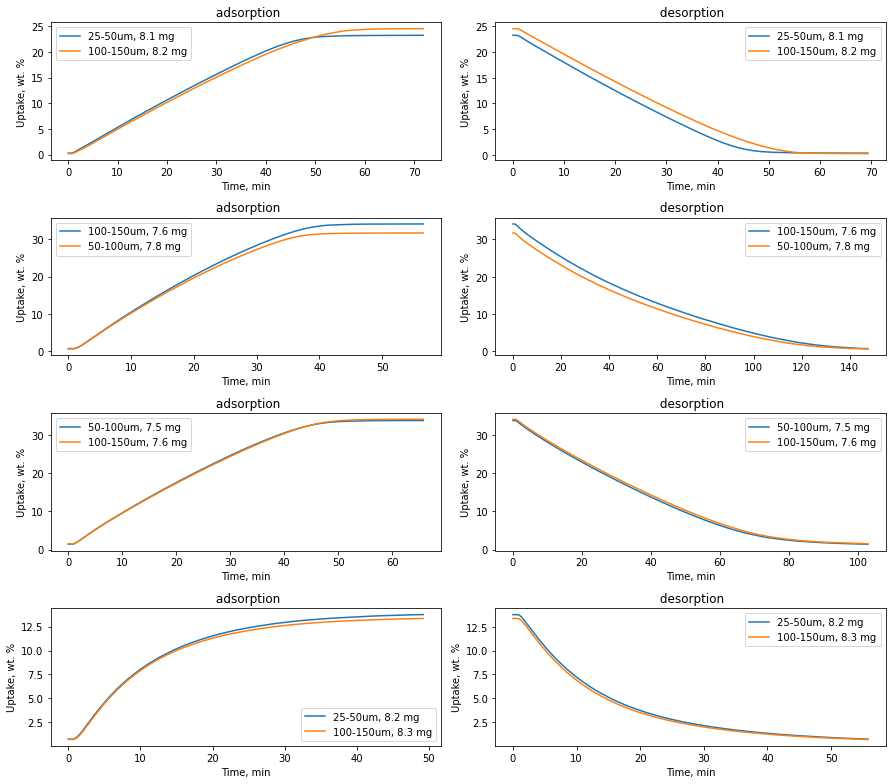

In [18]:

#################################
###    plot kinetics          ###
#################################
fig, ax = plt.subplots(4, 2, figsize=(12.5,11))

for m, Sorption_list in enumerate( Water_Sorption_list):
    for i, Sorption in enumerate([i[0] for i in Sorption_list]):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
        ax[m, 0].plot(Sorption.data.iloc[split_index_ads[1]:split_index_des[1], :]['time'] - Sorption.data.iloc[split_index_ads[1]:split_index_des[1], :]['time'].min(),
                 Sorption.data.iloc[split_index_ads[1]:split_index_des[1], :]['uptake'], 
                 label='{0}, {1:.1f} mg'.format(Sorption.filename.split('_')[2], Sorption.sample_mass)
                    )
        ax[m, 0].set_xlabel('Time, min', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 0].legend()
        ax[m, 1].plot(Sorption.data.iloc[split_index_des[1]:split_index_ads[2], :]['time'] - Sorption.data.iloc[split_index_des[1]:split_index_ads[2], :]['time'].min(),
                 Sorption.data.iloc[split_index_des[1]:split_index_ads[2], :]['uptake'], 
                 label='{0}, {1:.1f} mg'.format(Sorption.filename.split('_')[2], Sorption.sample_mass)
                    )
        ax[m, 1].set_xlabel('Time, min', fontsize=10)
        ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 1].legend()
    ax[m, 0].set_title('{0} adsorption'.format(path_list[m].split('/')[1]))
    ax[m, 1].set_title('{0} desorption'.format(path_list[m].split('/')[1]))
    

fig.tight_layout()
plt.show()

#### 0-60% humidity swing

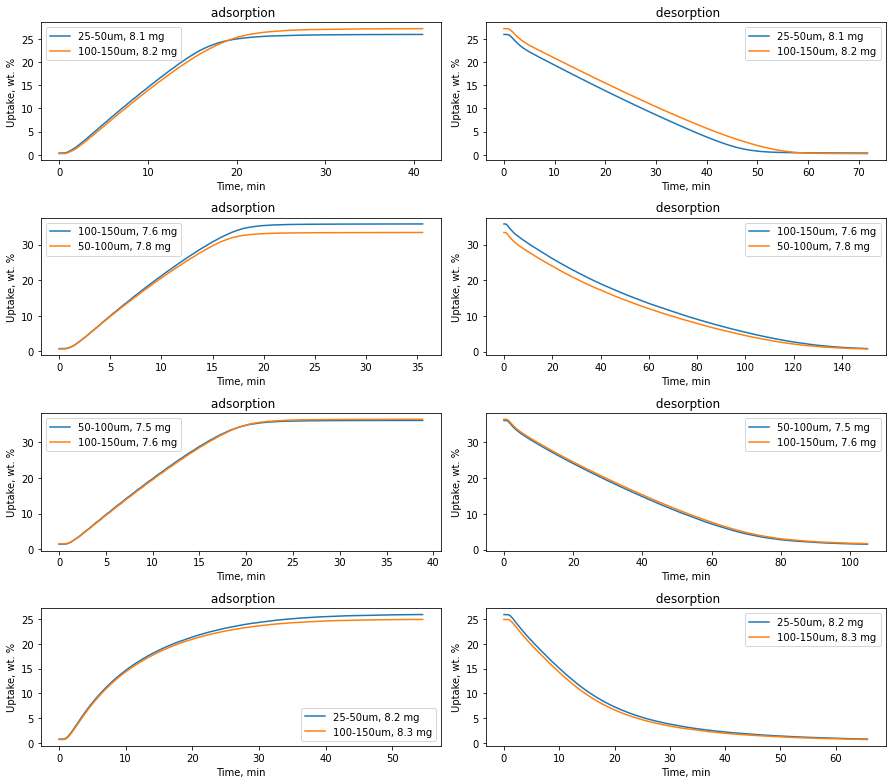

In [19]:
#################################
###    plot kinetics          ###
#################################
fig, ax = plt.subplots(4, 2, figsize=(12.5,11))

for m, Sorption_list in enumerate( Water_Sorption_list):
    for i, Sorption in enumerate([i[0] for i in Sorption_list]):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==60)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-60)].to_list()
        ax[m, 0].plot(Sorption.data.iloc[split_index_ads[1]:split_index_des[1], :]['time'] - Sorption.data.iloc[split_index_ads[1]:split_index_des[1], :]['time'].min(),
                 Sorption.data.iloc[split_index_ads[1]:split_index_des[1], :]['uptake'], 
                 label='{0}, {1:.1f} mg'.format(Sorption.filename.split('_')[2], Sorption.sample_mass)
                    )
        ax[m, 0].set_xlabel('Time, min', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 0].legend()
        ax[m, 1].plot(Sorption.data.iloc[split_index_des[1]:split_index_ads[2], :]['time'] - Sorption.data.iloc[split_index_des[1]:split_index_ads[2], :]['time'].min(),
                 Sorption.data.iloc[split_index_des[1]:split_index_ads[2], :]['uptake'], 
                 label='{0}, {1:.1f} mg'.format(Sorption.filename.split('_')[2], Sorption.sample_mass)
                    )
        ax[m, 1].set_xlabel('Time, min', fontsize=10)
        ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 1].legend()
    ax[m, 0].set_title('{0} adsorption'.format(path_list[m].split('/')[1]))
    ax[m, 1].set_title('{0} desorption'.format(path_list[m].split('/')[1]))
    

fig.tight_layout()
plt.show()

## Figures S37-38

In [20]:
#################################
###    import Sorption data   ###
#################################

path = '../../data/Variable flow/'

path_list = ['5mg/',
            '10mg/',
           
           ]
Water_Sorption_list = []
for pathname in path_list:
    Water_Sorption_list_path = []
    for Sorption_filename in [i for i in os.listdir(path+pathname) if 'isotherm' not in i]:
        Sorption = file_Sorption()
        try:
            Sorption.read_file(path+pathname,Sorption_filename)
            if Sorption.import_success:
                Water_Sorption_list_path.append(Sorption)
            else:
                del Sorption
                print(Sorption_filename, 'failed')
        except Exception as e:
            print(e)
            print(Sorption_filename, 'failed')
    Water_Sorption_list.append(sorted([(i, re.findall('[0-9]+', i.filename[:7])[0]) for i in Water_Sorption_list_path], key=lambda x: x[1])) 
    



Excel file format cannot be determined, you must specify an engine manually.
100flow-ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-26 10-22-20.dat failed
File 100flow-ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-26 10-22-20.xls read succesfull
Excel file format cannot be determined, you must specify an engine manually.
200flow_ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-26 00-10-44.dat failed
File 200flow_ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-26 00-10-44.xls read succesfull
Excel file format cannot be determined, you must specify an engine manually.
400flow-ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-25 14-51-36.dat failed
File 400flow-ROS-037_pureBatch_50-100um_5mg_flowRateVariation-2021-05-25 14-51-36.xls read succesfull
Excel file format cannot be determined, you must specify an engine manually.
100flow-ROS-037_pureBatch_50-100um_10mg_flowRateVariation-2021-05-26 10-22-20.dat failed
File 100flow-ROS-037_pureBatch_50

#### 0-30%RH humidity swing

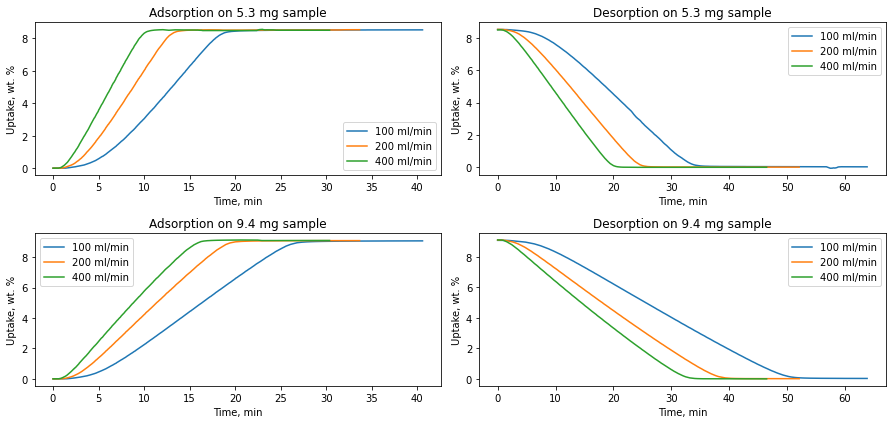

In [21]:

#################################
###    plot kinetics          ###
#################################
fig, ax = plt.subplots(2, 2, figsize=(12.5,6))

for m, Sorption_list in enumerate( Water_Sorption_list):
    for i, Sorption in enumerate([i[0] for i in Sorption_list]):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==30)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-30)].to_list()
        ax[m, 0].plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
                 Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
                 label='{0} ml/min'.format(int(re.findall('[0-9]+', Sorption.filename[:7])[0]))
                    )
        ax[m, 0].set_xlabel('Time, min', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 0].legend()
        ax[m, 1].plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
                 Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['uptake'], 
                 label='{0} ml/min'.format(int(re.findall('[0-9]+', Sorption.filename[:7])[0]))
                    )
        ax[m, 1].set_xlabel('Time, min', fontsize=10)
        ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 1].legend()
    ax[m, 0].set_title('Adsorption on {0:.1f} mg sample'.format(Sorption.sample_mass))
    ax[m, 1].set_title('Desorption on {0:.1f} mg sample'.format(Sorption.sample_mass))
    

fig.tight_layout()
plt.show()

#### 0-60%RH humidity swing

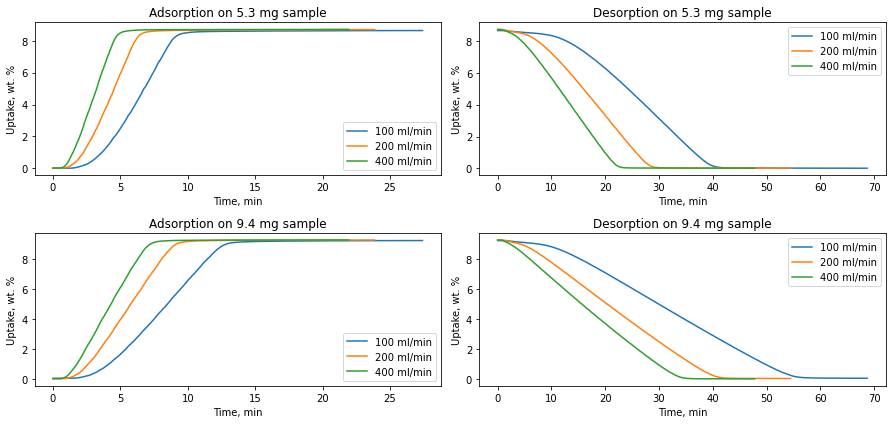

In [22]:

#################################
###    plot kinetics          ###
#################################
fig, ax = plt.subplots(2, 2, figsize=(12.5,6))

for m, Sorption_list in enumerate( Water_Sorption_list):
    for i, Sorption in enumerate([i[0] for i in Sorption_list]):
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']==60)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']==-60)].to_list()
        ax[m, 0].plot(Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'] - Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['time'].min(),
                 Sorption.data.iloc[split_index_ads[0]:split_index_des[0], :]['uptake'], 
                 label='{0} ml/min'.format(int(re.findall('[0-9]+', Sorption.filename[:7])[0]))
                    )
        ax[m, 0].set_xlabel('Time, min', fontsize=10)
        ax[m, 0].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 0].legend()
        ax[m, 1].plot(Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'] - Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['time'].min(),
                 Sorption.data.iloc[split_index_des[0]:split_index_ads[1], :]['uptake'], 
                 label='{0} ml/min'.format(int(re.findall('[0-9]+', Sorption.filename[:7])[0]))
                    )
        ax[m, 1].set_xlabel('Time, min', fontsize=10)
        ax[m, 1].set_ylabel('Uptake, wt. %', fontsize=10, )
        ax[m, 1].legend()
    ax[m, 0].set_title('Adsorption on {0:.1f} mg sample'.format(Sorption.sample_mass))
    ax[m, 1].set_title('Desorption on {0:.1f} mg sample'.format(Sorption.sample_mass))
    

fig.tight_layout()
plt.show()